# NeSy4PPM: Neuro-Symbolic Predictive Process Monitoring Tutorial

NeSy4PPM supports both single-attribute (e.g., activity) and multi-attribute (e.g., activity and resource) suffix prediction in predictive process monitoring. It implements a Neuro-Symbolic (NeSy) system that integrates neural models (LSTM, Transformer) with various types of symbolic background knowledge (BK), enabling accurate and compliant predictions even under concept drift.

This notebook walks through the entire NeSy4PPM pipeline, including:

    1. Data preparation
    2. Learning pipeline
       A. Prefixes preprocessing
       B. Neural Network training
    3. Prediction pipeline

# 1. Data preparation
The first step in the NeSy4PPM pipeline is to load and transform the event log (in a .xes, .csv or .xes.gz files) into a symbolic representation using the `LogData` class, where activity and resource labels are mapped to unique ASCII characters. Depending on the input configuration, the log can be:
- A **single event log**, which will be automatically split into training and evaluation subsets based on the case start timestamps.
- A pair of **separate training and test logs**, which will be loaded and concatenated internally.

## Single event log:

In [2]:
from pathlib import Path
from NeSy4PPM.commons import log_utils

log_path = Path.cwd().parent/'data'/'input'/'logs'
log_name = "helpdesk.xes"
train_ratio = 0.8
case_name_key = 'case:concept:name'
act_name_key = 'concept:name'
res_name_key = 'org:resource'
timestamp_key = 'time:timestamp'

log_data = log_utils.LogData(log_path=log_path,log_name=log_name,train_ratio=train_ratio,
                             case_name_key=case_name_key,act_name_key=act_name_key,
                             res_name_key=res_name_key,timestamp_key=timestamp_key,resource=True)
print(f"Loaded log: {log_data.log_name}")
print(f"Trace max size: {log_data.max_len}")

Exception: File does not exist at path: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\data\input\logs\helpdesk.xes

## Separate training and test logs:

In [4]:
from pathlib import Path
from NeSy4PPM.commons import log_utils

log_path = Path.cwd().parent/'data'/'input'/'logs'
train_log = "helpdesk_train.xes"
test_log = "helpdesk_test.xes"

log_data = log_utils.LogData(log_path=log_path,train_log=train_log,test_log=test_log,resource=True)
print(f"Loaded log: {log_data.log_name}")
print(f"Trace max size: {log_data.max_len}")

parsing log, completed traces :: 100%|██████████| 820/820 [00:00<00:00, 9614.15it/s]


Loaded log: helpdesk_train
Trace max size: 15


# 2. Learning pipeline
The __Learning Pipeline__ is responsible for transforming symbolic traces into neural-compatible inputs and training an LSTM or Transformer model to perform next activity and resource prediction. This phase involves both __Prefixes preprocessing__ by extracting and encoding prefixes form training set, and __Neural network training__ that learn to generate the most likely continuations of incomplete process traces.

## A. Prefixes preprocessing
The `Prefixes preprocessing` step extracts prefixes (i.e., partial traces executions) from the training log and encodes them into numerical representations suitable for neural models. This can be done by calling `extract_trace_prefixes` and `encode_prefixes` for extracting and encoding prefixes, respectively or only by calling `extract_encode_prefixes` function.

### Step 1: Prefixes extraction
The `extract_trace_prefixes` function extracts all possible prefixes from each trace in the training log, up to a predefined maximum length. These prefixes represent partial executions of cases and are used as inputs to the neural model.

In [13]:


from NeSy4PPM.learning.prefixes_preprocessing import extract_trace_prefixes

extracted_prefixes = extract_trace_prefixes(log_data=log_data, resource=True)

### Step 2: Prefixes encodings
Before training a neural model, extracted prefixes must be converted into vectorized formats. NeSy4PPM supports four encoding techniques for multi-attribute: 
- `One-hot encoding`,
- `Index-based encoding`,
- `Shrinked index-based encoding`, 
- `Multi-encoders encoding`.

Each encoding is implemented via the function `encode_prefixes` and prepares both input features (`x`) and two targets labels: `y_a` for activity prediction and `y_g` for resource prediction.

#### a. One-hot encoding
In the __One-hot encoding__, sequences of events are converted into high-dimensional binary feature vectors. Each feature corresponds to a concatenation of one-hot encoded activity and resource values derived from the log. To apply index-based encoding, set the `encoder` parameter to `Encodings.One_hot` when calling the `encode_prefixes` function:

In [5]:
from NeSy4PPM.learning.prefixes_preprocessing import encode_prefixes
from NeSy4PPM.commons.utils import Encodings

x, y_a, y_g= encode_prefixes(log_data,prefixes=extracted_prefixes,encoder=Encodings.One_hot,resource=True)

Total groups: 22 - Target groups: 23
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶']
Total chars: 14 - Target chars: 15
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®']
Num. of training sequences: 16937
Vectorization...
Num. of features: 36


#### b. Index-based encoding
In the __Index-based encoding__, sequences of events are transformed into numerical feature vectors, where each event is represented by a pair of indices: one for the activity and one for the resource. These indices correspond to the positions of the activity and resource in their respective predefined sets. To apply index-based encoding, set the `encoder` parameter to `Encodings.Index_based` when calling the `encode_prefixes` function:

In [14]:
from NeSy4PPM.learning.prefixes_preprocessing import encode_prefixes
from NeSy4PPM.commons.utils import Encodings

x, y_a, y_g = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=Encodings.Index_based,resource=True)

Total groups: 22 - Target groups: 23
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶']
Total chars: 14 - Target chars: 15
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®']
Num. of training sequences: 16937
Vectorization...
Num. of features: 30


#### c. Shrinked index-based encoding
In the __Shrinked index-based encoding__, sequences of events are transformed into numerical feature vectors by assigning a unique integer index to each activity–resource pair. To apply shrinked index-based encoding, set the encoder parameter to `Encodings.Shrinked_based` when calling the `encode_prefixes` function:

In [15]:
from NeSy4PPM.learning.prefixes_preprocessing import encode_prefixes
from NeSy4PPM.commons.utils import Encodings

x, y_a, y_g = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=Encodings.Shrinked_based, resource=True)

Total groups: 22 - Target groups: 23
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶']
Total chars: 14 - Target chars: 15
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®']
Num. of training sequences: 16937
Vectorization...
Num. of features: 15


#### d. Multi-encoders encoding
In the __Multi-encoders encoding__, sequences of events are represented using separate embedding spaces for activities and resources. Each activity and resource is first embedded independently, and then enriched with cross-information using a modulation mechanism that captures their interactions. The final representation combines the modulated embeddings using learned alignment weights. To apply multi-encoders encoding, set the encoder parameter to `Encodings.Multi_encoders` when calling the `encode_prefixes` function:

In [16]:
from NeSy4PPM.learning.prefixes_preprocessing import encode_prefixes
from NeSy4PPM.commons.utils import Encodings

x, y_a, y_g = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=Encodings.Multi_encoders, resource=True)

Total groups: 22 - Target groups: 23
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶']
Total chars: 14 - Target chars: 15
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®']
Num. of training sequences: 16937
Vectorization...
Num. of features: 15


### Steps 1&2: End-to-end prefixes preprocessing

In [5]:
from NeSy4PPM.learning.prefixes_preprocessing import extract_encode_prefixes
from NeSy4PPM.commons.utils import Encodings

encoder = Encodings.Index_based
x, y_a, y_g = extract_encode_prefixes(log_data, encoder=encoder, resource=True)

Total groups: 22 - Target groups: 23
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶']
Total chars: 14 - Target chars: 15
	 ['¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®']
Num. of training sequences: 16937
Vectorization...
Num. of features: 30


## B. Neural Network training
Once the prefixes are encoded, NeSy4PPM proceeds to train a neural network that learns to predict the next activity and resource given a partial trace. The training is handled via the `train` function, which takes the encoded prefix data (`x`, `y_a`, `y_g`) and builds a model according to the chosen architecture. NeSy4PPM supports two neural architectures:

- __LSTM (Long Short-Term Memory)__ networks, which are recurrent neural networks designed to handle sequential data with long-range dependencies. To use LSTM, set the `model_arch` parameter to `NN_model.LSTM`.
- __Transformer__ architectures, which use attention mechanisms to model relationships across all positions in the prefix sequence simultaneously. To use a Transformer, set the `model_arch` parameter to `NN_model.Transformer`.

Build model...
Checkpoint path: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\0\models\CFR\helpdesk_train
Checkpoint name pattern: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\0\models\CFR\helpdesk_train\model_{epoch:03d}-{val_loss:.3f}.keras
Epoch 1/100


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

847/847 - 6s - loss: 2.8879 - act_output_loss: 1.0917 - group_output_loss: 1.7962 - val_loss: 1.7846 - val_act_output_loss: 0.5545 - val_group_output_loss: 1.2300 - lr: 0.0010 - 6s/epoch - 7ms/step
Epoch 2/100
847/847 - 3s - loss: 1.6146 - act_output_loss: 0.5622 - group_output_loss: 1.0524 - val_loss: 1.4697 - val_act_output_loss: 0.5099 - val_group_output_loss: 0.9598 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 3/100
847/847 - 4s - loss: 1.4256 - act_output_loss: 0.5148 - group_output_loss: 0.9108 - val_loss: 1.3587 - val_act_output_loss: 0.4757 - val_group_output_loss: 0.8830 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 4/100
847/847 - 4s - loss: 1.3413 - act_output_loss: 0.4922 - group_output_loss: 0.8491 - val_loss: 1.3143 - val_act_output_loss: 0.4642 - val_group_output_loss: 0.8502 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 5/100
847/847 - 4s - loss: 1.2973 - act_output_loss: 0.4796 - group_output_loss: 0.8176 - val_loss: 1.2697 - val_act_output_loss: 0.4447 - val_group_output_loss: 0.82

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\JOukharijane\\Desktop\\PostDoc\\NeSy4PPM\\venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\JOukharijane\\Desktop\\PostDoc\\NeSy4PPM\\venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Us

Build model...


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

Checkpoint path: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\1\models\CFR\helpdesk_train
Checkpoint name pattern: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\1\models\CFR\helpdesk_train\model_{epoch:03d}-{val_loss:.3f}.keras
Epoch 1/100
847/847 - 7s - loss: 2.7288 - act_output_loss: 1.0166 - group_output_loss: 1.7122 - val_loss: 1.7080 - val_act_output_loss: 0.5709 - val_group_output_loss: 1.1371 - lr: 0.0010 - 7s/epoch - 8ms/step
Epoch 2/100
847/847 - 5s - loss: 1.6037 - act_output_loss: 0.5790 - group_output_loss: 1.0247 - val_loss: 1.4554 - val_act_output_loss: 0.5043 - val_group_output_loss: 0.9510 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 3/100
847/847 - 5s - loss: 1.4237 - act_output_loss: 0.5264 - group_output_loss: 0.8973 - val_loss: 1.3488 - val_act_output_loss: 0.4756 - val_group_output_loss: 0.8733 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 4/100
847/847 - 5s - loss: 1.3419 - a

C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

847/847 - 6s - loss: 2.6272 - act_output_loss: 0.9510 - group_output_loss: 1.6762 - val_loss: 1.7354 - val_act_output_loss: 0.5671 - val_group_output_loss: 1.1682 - lr: 0.0010 - 6s/epoch - 7ms/step
Epoch 2/100
847/847 - 5s - loss: 1.5983 - act_output_loss: 0.5702 - group_output_loss: 1.0280 - val_loss: 1.4681 - val_act_output_loss: 0.5226 - val_group_output_loss: 0.9455 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 3/100
847/847 - 6s - loss: 1.4182 - act_output_loss: 0.5160 - group_output_loss: 0.9022 - val_loss: 1.3653 - val_act_output_loss: 0.4899 - val_group_output_loss: 0.8754 - lr: 0.0010 - 6s/epoch - 7ms/step
Epoch 4/100
847/847 - 6s - loss: 1.3433 - act_output_loss: 0.4914 - group_output_loss: 0.8519 - val_loss: 1.2967 - val_act_output_loss: 0.4596 - val_group_output_loss: 0.8371 - lr: 0.0010 - 6s/epoch - 7ms/step
Epoch 5/100
847/847 - 5s - loss: 1.2935 - act_output_loss: 0.4746 - group_output_loss: 0.8188 - val_loss: 1.2809 - val_act_output_loss: 0.4550 - val_group_output_loss: 0.82

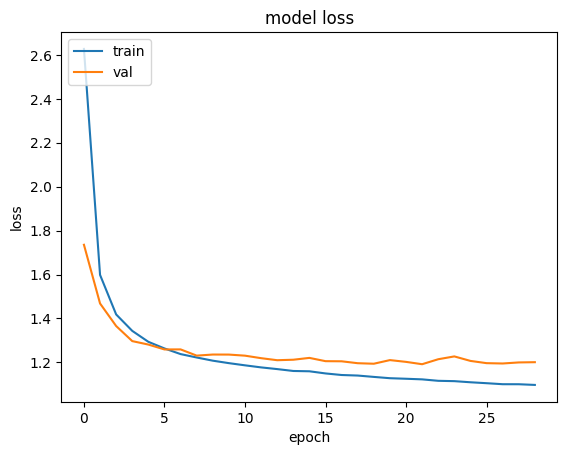

In [7]:
from NeSy4PPM.learning.train_model import train
from NeSy4PPM.commons.utils import NN_model

model = NN_model.Transformer
model_folder= Path.cwd().parent/'data'/'output'
train(log_data, encoder, model_arch=model, output_folder=model_folder, x=x, y_a=y_a, y_g=y_g)

# 3. Prediction pipeline
The __Prediction Pipeline__ in NeSy4PPM is responsible for generating multi-attribute (activity and resource) suffix predictions from a prefix (i.e., an incomplete trace) using a trained neural model. To enhance both accuracy and compliance under concept drift, it supports two main prediction modes:
- __BK-contextualized Beam Search__: the BK is used *during* beam search to guide which branches are explored based on compliance.
- __BK-based Filtering__: the BK is used *after* the beam search to filter out non-compliant predicted suffixes.


## Step 1: Set prediction parameters
The prediction process begins by specifying the following parameters that control how the prediction algorithm operates:
- `log_data.evaluation_prefix_start`: the minimum prefix length (in events) for prediction.
- `log_data.evaluation_prefix_end`: the maximum prefix length for prediction.
- `model`: the trained model architecture (`NN_model.LSTM` or `NN_model.Transformer`).
- `encoder`: the encoding method used during training (`Encodings.One_hot`, `Encodings.Index_based`, `Encodings.Shrinked_index_based` or `Encodings.Multi_Encoders` ).
- `output_folder`: the path where the trained model and prediction results are saved.
- `bk_file_path`: the path where the `BK` file exists.
- `beam_size`: the number of alternative suffixes explored in parallel by the beam search.
- `weight`: a float value in [0, 1] that balances the importance of neural predictions and BK compliance. A lower value emphasizes the neural model; a higher value gives more importance to BK.
- `BK_end`: a boolean parameter indicating whether BK is applied at the end (i.e., filtering) instead of during the search.


In [ ]:
from NeSy4PPM.commons.utils import NN_model
from NeSy4PPM.commons.utils import Encodings

(log_data.evaluation_prefix_start, log_data.evaluation_prefix_end) = (1,4)
model = NN_model.Transformer
encoder = Encodings.Index_based
output_folder= Path.cwd().parent/'data'/'output'
bk_file_path = Path.cwd().parent/'data'/'input'/'declare_models'/'BK_helpdesk.decl'
beam_size = 3
weight = [0.9]
BK_end = False

## Step 2: Load the Background Knowledge (BK)
After setting the parameters, a background knowledge (BK) model must be loaded using the `load_bk` function. For multi-attribute prediction, only MP-declare models (`.decl`) are supported.

In [ ]:
from NeSy4PPM.commons.utils import load_bk

bk_model = load_bk(bk_file_path)

## Step 3: Perform Prediction
NeSy4PPM implements the `predict_evaluate` function, which generates activity-resource suffixes using the proposed neuro-symbolic beam search algorithm and computes two evaluation metrics:
   - __Damerau-Levenshtein Similarity__, measuring the similarity between the predicted and actual suffixes based on edit distance,
   - __Jaccard Similarity__, measuring the overlap between the sets of predicted and actual activities. suffix prediction using a trained neural model and loaded `BK` model.

By default, this function operates on the __entire test log__, predicting suffixes for all traces defined in the test set. However, it can also be used to predict suffixes for a specific __subset of traces__ by providing a list of case IDs from the test log.

In [ ]:
### Entire test log prediction
from NeSy4PPM.prediction import evaluation

evaluation.predict_evaluate(log_data, model=model, encoder=encoder,
                            output_folder=output_folder, bk_model=bk_model, beam_size=beam_size, weight=weight, resource=True)

In [ ]:
### A subset of test log prediction
from NeSy4PPM.prediction import evaluation
traces_ids = ['Case 1327']
evaluation.predict_evaluate(log_data, model=model, encoder=encoder,evaluation_trace_ids= traces_ids,
                            output_folder=output_folder, bk_model=bk_model, beam_size=beam_size, weight=weight, resource=True)